In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import norm
import math
import sidetable

In [15]:
survey = pd.read_csv("./surveydata.csv")
#how many observations
print(survey.SubjectID.count())
#unique ID
print(len(pd.unique(survey['SubjectID'])))
#unique description, 5 questions
print(pd.unique(survey['description']))
#print(max(survey['Unnamed:0']))
survey.head()

5540
37
['Numeric answer for number of hours of sleep for participant on night before the run'
 'Approximate time of day when run was performed'
 'Type of surface (soft, hard, etc) for route that participant ran'
 'General descriptions of running surface conditions (dry, wet, icy, etc)'
 'RPE scale 1-10 of workout difficulty']


,Unnamed: 0,Unnamed: 0.1,description,filename,name,numerical_ans,textual_ans,SubjectID,Year,Date,DataSource
0,0,0,Numeric answer for number of hours of sleep fo...,58_20180811_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),NaN,7.5,58,2018,811,surveydata.csv
1,1,1,Approximate time of day when run was performed,58_20180811_surveydata.csv,MT Run Follow Up - Time of Run,NaN,8:03:00 AM,58,2018,811,surveydata.csv
2,2,2,"Type of surface (soft, hard, etc) for route th...",58_20180811_surveydata.csv,MT Run Follow Up - Surface,NaN,"Hard (sidewalk, asphalt)",58,2018,811,surveydata.csv
3,3,3,General descriptions of running surface condit...,58_20180811_surveydata.csv,MT Run Follow Up - Surface Conditions,NaN,Dry,58,2018,811,surveydata.csv
4,4,4,RPE scale 1-10 of workout difficulty,58_20180811_surveydata.csv,MT Run Follow Up - How Was Your Workout,NaN,3 - Moderate,58,2018,811,surveydata.csv


In [16]:
#Lets clean this data

#Drop 2 first columns
survey.drop(survey.columns[[0, 1]], axis=1, inplace=True)

In [28]:
#Create key variables

#For a unique survey, we can make a key variable concatenating  (SubjectID, Year and Date)
cols = ['SubjectID', 'Year', 'Date'] #This key variable might help to find same observation in the garmin database
survey['key'] = survey[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#For a unique observation in the survey, we can make a key2 with (SubjectID, Year, Date and description)
cols2 = ['SubjectID', 'Year', 'Date','description']
survey['key2'] = survey[cols2].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#Count how many possible mistakes, duplicate observations may have
print(survey[survey.duplicated(subset=['key2'],keep=False)].SubjectID.count())
#53 from 5540 obs is not bad

#Lets just look to the first one
key_look = '424_2017_617'
survey[survey.key == key_look]


53


,description,filename,name,numerical_ans,textual_ans,SubjectID,Year,Date,DataSource,key,key2
462,Numeric answer for number of hours of sleep fo...,424_20170617_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),6.0,NaN,424,2017,617,surveydata.csv,424_2017_617,424_2017_617_Numeric answer for number of hour...
463,Approximate time of day when run was performed,424_20170617_surveydata.csv,MT Run Follow Up - Time of Run,NaN,'8:00:00 AM',424,2017,617,surveydata.csv,424_2017_617,424_2017_617_Approximate time of day when run ...
464,"Type of surface (soft, hard, etc) for route th...",424_20170617_surveydata.csv,MT Run Follow Up - Surface,NaN,"Hard (sidewalk, asphalt)",424,2017,617,surveydata.csv,424_2017_617,"424_2017_617_Type of surface (soft, hard, etc)..."
465,General descriptions of running surface condit...,424_20170617_surveydata.csv,MT Run Follow Up - Surface Conditions,NaN,Dry,424,2017,617,surveydata.csv,424_2017_617,424_2017_617_General descriptions of running s...
466,Numeric answer for number of hours of sleep fo...,424_20170617_surveydata.csv,MT Run Follow Up - Previous Nights Sleep (hours),NaN,6.00,424,2017,617,surveydata.csv,424_2017_617,424_2017_617_Numeric answer for number of hour...
467,Approximate time of day when run was performed,424_20170617_surveydata.csv,MT Run Follow Up - Time of Run,NaN,8:04:00 AM,424,2017,617,surveydata.csv,424_2017_617,424_2017_617_Approximate time of day when run ...


In [20]:
for col in survey.columns:
    pct_missing = np.mean(survey[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

description - 0%
filename - 0%
name - 0%
numerical_ans - 98%
textual_ans - 2%
SubjectID - 0%
Year - 0%
Date - 0%
DataSource - 0%
key - 0%


In [34]:
garmin = pd.read_csv("./garmindata.csv")

#how many observations
print(garmin.SubjectID.count())
#unique ID
print(len(pd.unique(garmin['SubjectID'])))

garmin.head()

6412029
38


,Unnamed: 0,Unnamed: 0.1,filename,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.position_lat[semicircles],record.position_long[semicircles],record.speed[m/s],record.timestamp[s],SubjectID,Year,Date,DataSource
0,5,5,58_20180916_garmindata.csv,1117.2,3.17,78.0,609492677.0,-1.361950e+09,1.465,0.0,58,2018,916,garmindata.csv
1,6,6,58_20180916_garmindata.csv,1116.4,7.93,78.0,609493159.0,-1.361951e+09,2.305,2.0,58,2018,916,garmindata.csv
2,7,7,58_20180916_garmindata.csv,1116.2,10.39,82.0,609493416.0,-1.361951e+09,2.454,3.0,58,2018,916,garmindata.csv
3,8,8,58_20180916_garmindata.csv,1116.2,12.91,86.0,609493682.0,-1.361951e+09,2.463,4.0,58,2018,916,garmindata.csv
4,9,9,58_20180916_garmindata.csv,1116.0,15.66,86.0,609493973.0,-1.361951e+09,2.547,5.0,58,2018,916,garmindata.csv


In [35]:
#Lets explore this data

#Drop 2 first columns
garmin.drop(garmin.columns[[0, 1]], axis=1, inplace=True)

In [36]:
#Create key variables

#For a unique observation, we can make a key variable concatenating  (SubjectID, Year and Date)
cols = ['SubjectID', 'Year', 'Date'] #This key variable might help to find same observation in the survey database
garmin['key'] = garmin[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#unique ID
print(len(pd.unique(garmin['key'])))
#average observations per runner
print(len(pd.unique(garmin['key']))/37)
#data per observation
garmin.groupby('key')['SubjectID'].count()


,filename,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.position_lat[semicircles],record.position_long[semicircles],record.speed[m/s],record.timestamp[s],SubjectID,Year,Date,DataSource,key
276286,424_20170617_garmindata.csv,1215.6,4.79,124.0,608901780.0,-1.362250e+09,2.342,0.0,424,2017,617,garmindata.csv,424_2017_617
276287,424_20170617_garmindata.csv,1215.4,7.29,123.0,608901725.0,-1.362250e+09,2.342,1.0,424,2017,617,garmindata.csv,424_2017_617
276288,424_20170617_garmindata.csv,1215.2,9.94,123.0,608901676.0,-1.362250e+09,2.342,2.0,424,2017,617,garmindata.csv,424_2017_617
276289,424_20170617_garmindata.csv,1215.4,12.48,123.0,608901629.0,-1.362249e+09,2.482,3.0,424,2017,617,garmindata.csv,424_2017_617
276290,424_20170617_garmindata.csv,1215.4,15.09,122.0,608901543.0,-1.362249e+09,2.575,4.0,424,2017,617,garmindata.csv,424_2017_617
...,...,...,...,...,...,...,...,...,...,...,...,...,...
281298,424_20170617_garmindata.csv,1049.8,10431.47,111.0,609000034.0,-1.360770e+09,0.177,5078.0,424,2017,617,garmindata.csv,424_2017_617
281299,424_20170617_garmindata.csv,1049.8,10431.47,113.0,609000019.0,-1.360770e+09,0.177,5079.0,424,2017,617,garmindata.csv,424_2017_617
281300,424_20170617_garmindata.csv,1049.8,10431.47,112.0,608999998.0,-1.360770e+09,0.168,5080.0,424,2017,617,garmindata.csv,424_2017_617
281301,424_20170617_garmindata.csv,1049.8,10431.47,111.0,609000000.0,-1.360770e+09,0.168,5081.0,424,2017,617,garmindata.csv,424_2017_617


In [46]:
#average data per observation
sum(garmin.groupby('key')['SubjectID'].count())/len(garmin.groupby('key')['SubjectID'].count())




1657


3869.661436330718

In [47]:
#Lets just look to the same day as the one looked for survey
key_look = '424_2017_617'
df = garmin[garmin.key == key_look]
#Sorting data by record.timestamp[s]
df.sort_values(by=['record.timestamp[s]'])

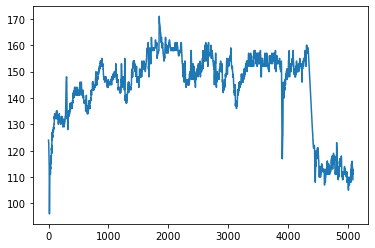

In [50]:
#Lets plot the heart rate over all the running
plt.plot(df['record.timestamp[s]'], df['record.heart_rate[bpm]']) 

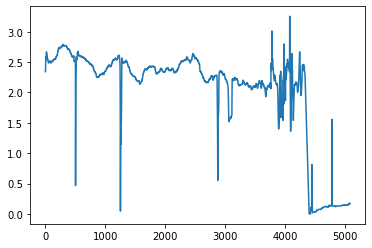

In [51]:
#Lets plot the speed over all the running
plt.plot(df['record.timestamp[s]'], df['record.speed[m/s]']) 



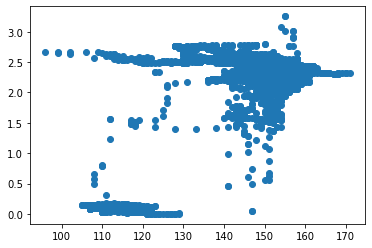

In [54]:
#Lets plot the heart rate vs. speed 
plt.scatter(df['record.heart_rate[bpm]'], df['record.speed[m/s]']) 
